# SAC++ (Soft Actor-Critic++)

SAC (Soft Actor-Critic) is a widely-used algorithm in reinforcement learning, building upon the **off-policy** DDPG (Deep Deterministic Policy Gradient) framework discussed in our writing assignment. Unlike DDPG, SAC incorporates **entropy regularization** and trains a **stochastic policy** instead of a deterministic one.

To further help understand the concept in SAC, we briefly introduce the entropy idea. 

Entropy, denoted as 
$$
H(P) = -\int P(x) \log P(x) \, dx = \mathbb{E}_x[-\log P(x)],
$$ 
measures the randomness of the policy's action distribution $P(\cdot)$. Intuitively, higher entropy implies more exploration, while lower entropy indicates more exploitation.

**Example:**

- **Uniform Distribution (High Entropy):**
  
  Consider a discrete distribution with 8 equally likely states:
  $$
  P = \left(\frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}\right)
  $$
  The entropy is:
  $$
  H(P) = -\sum_{i=1}^{8} P(x_i) \log_2 P(x_i) = -8 \times \frac{1}{8} \log_2 \frac{1}{8} = 3 \text{ bits}
  $$
  
- **Skewed Distribution (Lower Entropy):**
  
  Now, consider a more deterministic distribution:
  $$
  P = \left(\frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \frac{1}{16}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}\right)
  $$
  The entropy decreases to:
  $$
  H(P) = -\frac{1}{2} \log_2 \frac{1}{2} - \frac{1}{4} \log_2 \frac{1}{4} - \frac{1}{8} \log_2 \frac{1}{8} - \frac{1}{16} \log_2 \frac{1}{16} - 4 \times \frac{1}{64} \log_2 \frac{1}{64} = 2 \text{ bits}
  $$
  
As demonstrated, entropy diminishes as the distribution becomes more deterministic.

> **Note:** In continuous action spaces, the Gaussian distribution maximizes entropy.

In SAC, the reward expectation is modified to include the entropy term:
$$
r_t + \gamma (1 - d_t) \left(Q_{\phi'} + \alpha H(P)\right),
$$ 
where $\alpha$ is the **entropy temperature** parameter that balances exploration and exploitation. This adjustment ensures that even if the estimated Q-value increases, significant reductions in entropy can prevent premature convergence to suboptimal policies.

**Concrete Example:**

- **Stochastic Policy:**
  
  Suppose a policy generates actions with probabilities:
  $$
  P(a_1) = 0.5, \quad P(a_2) = 0.5
  $$
  This distribution has higher entropy, promoting exploration between actions $a_1$ and $a_2$.
  
- **Deterministic Policy:**
  
  Alternatively, if the policy generates actions with:
  $$
  P(a_1) = 0.9, \quad P(a_2) = 0.1,
  $$
  the entropy is lower, indicating a preference for action $a_1$ and less exploration.

In SAC, we utilize a **continuous action space** with a **Gaussian policy** instead of discrete actions as in DDPG. This approach allows for more nuanced and precise action selections, enhancing exploration in complex environments. Follow the coding box and instructions below to complete this SAC implementation.

For more details on DDPG, refer to the original paper [here](https://arxiv.org/pdf/1509.02971).


In [3]:
import random
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Normal

In order to prevent from overflows, I apply double precision for float operations.

In [4]:
torch.set_default_dtype(torch.float64)

Differentitate the use case from our basic coding questions, we are using Pendulum task with continuous action space. 

In [5]:
env = gym.make("Pendulum-v1")

Unlike DDPG, SAC trains a stochastic policy $ \pi_{\theta}(\cdot) $ (where $ \theta $ is parameters) instead of a deterministic policy $ \mu_{\theta}(\cdot) $. <br>
Note : For the bounded continuous action space between $ l $ and $ h $, use Gaussian distribution as follows.<br>
$$ P(\cdot | \pi_\theta(s)) = ((\mathcal{N}(tanh(\mu_{\theta}(s)), \sigma_{\theta}(s)) + 1.0) / 2.0) \times (h - l) + l  $$
Based on the mathematical form above, please implement the GaussianPolicy below.

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

# Policy net (pi_theta)
class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(GaussianPolicy, self).__init__()
        
        #############################################################################################
        # TODO: Design the network architecture for mu (mean) and sigma (standard deviation), respectively.
        self.mean = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions),
            nn.ReLU()
        )
        self.log_std = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions),
            nn.ReLU()
        )

        #############################################################################################
        
        self.apply(weights_init_)
        
        #############################################################################################
        # TODO: action rescaling based on action_space
        # Hint: self.action_scale = ??
        # Hint: self.action_bias = ??
        
        self.action_scale = torch.tensor((env.action_space.high - env.action_space.low) / 2.)
        self.action_bias = torch.tensor((env.action_space.high + env.action_space.low) / 2.)
        #############################################################################################


    def forward(self, state):
        
        #############################################################################################
        # TODO: Complete forward function
        # Hint: Remember to use LOG_SIG_MIN and LOG_SIG_MAX for log clipping
        mean = self.mean(state)
        log_std = self.log_std(state)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        
        #############################################################################################

        return mean, log_std

    def sample(self, state):
        #############################################################################################
        # TODO: Complete sample function given state
        # TODO: Return sampled action, log_prob (Derive it from Gaussian Policy), mean (of the Gaussian)
        # Hint: For reparameterization trick (mean + std * N(0,1))
        # Hint: Remember to Enforcing Action Bound using self.action_scale, self.action_bias
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        sampled_action = normal.rsample()
        compressed_action = torch.tanh(sampled_action)
        action = compressed_action * self.action_scale + self.action_bias
        log_prob = normal.log_prob(sampled_action) - torch.log(self.action_scale * (1 - compressed_action.pow(2)) + epsilon)
        log_prob = log_prob.sum(dim=1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        
        #############################################################################################
        return action, log_prob, mean

    def to(self, device):
        # If you are using self.action_scale, self.action_bias for action rescaling
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super(GaussianPolicy, self).to(device)

################################## Hyper-parameters Tuning ##################################

HIDDEN_DIM = 8
actor_lr = 0.1

#############################################################################################


num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
policy = GaussianPolicy(num_inputs, num_actions, hidden_dim=HIDDEN_DIM, action_space=env.action_space).to(device)
policy_optim = torch.optim.AdamW(policy.parameters(), actor_lr)

### Double Q-Learning Introduction

In traditional Q-learning, a single Q-function is used to estimate the value of state-action pairs, which can often lead to overestimation bias during training. Double Q-learning addresses this by maintaining two separate Q-networks - $ Q_{\phi_1}(s), Q_{\phi_2}(s) $ - to estimate Q-values more accurately. The key idea is that, instead of relying on a single network to both select and evaluate actions, we alternate between the two networks. At each time step, one network selects the action, and the other evaluates its value, reducing overestimation bias.

To further enhance stability, we also utilize two target networks - $ Q_{\phi_1^{\prime}}(s), Q_{\phi_2^{\prime}}(s) $ - to generate stable target values for updates. The target value is computed by taking the minimum of the two Q-value estimates from the target networks, as follows:

$$
y = r + \gamma \min\left(Q_{\phi_1^{\prime}}(s', \pi_{\phi}(s')), Q_{\phi_2^{\prime}}(s', \pi_{\phi}(s'))\right)
$$

By using two Q-networks and taking the minimum of their estimates, we reduce the risk of bias in our value estimates and ensure more stable learning throughout the training process.


In [7]:
class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()
        
        #############################################################################################
        # TODO: Design the 2 networks for Q_1 and Q_2 recording from Double Q-Learning
        
        # Q1 architecture
        self.q1 = nn.Sequential(
            nn.Linear(num_inputs + num_actions, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Q2 architecture
        self.q2 = nn.Sequential(
            nn.Linear(num_inputs + num_actions, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        
        
        #############################################################################################

        self.apply(weights_init_)

    def forward(self, state, action):
        
        #############################################################################################
        # TODO: Complete forward function
        # TODO: Return Q_1(s, a) and Q_2(s, a)
        # Hint: Simple concatenation should work fine: xu = torch.cat([state, action], 1)
        if state.dim() == 2 and action.dim() == 2:
            x1 = self.q1(torch.cat([state, action], dim=1))
            x2 = self.q2(torch.cat([state, action], dim=1))
        elif state.dim() == 3 and action.dim() == 3:
            x1 = self.q1(torch.cat([state, action], dim=2))
            x2 = self.q2(torch.cat([state, action], dim=2))
        else:
            raise ValueError(f"Incompatible dimensions: state {state.shape}, action {action.shape}")
        
        #############################################################################################

        return x1, x2

################################## Hyper-parameters Tuning ##################################

HIDDEN_DIM = 8
critic_lr = 0.1

#############################################################################################


critic = QNetwork(num_inputs, num_actions, hidden_dim=HIDDEN_DIM).to(device)  # Q_phi
critic_target = QNetwork(num_inputs, num_actions, hidden_dim=HIDDEN_DIM).to(device)  # Q_phi'
_ = critic_target.requires_grad_(False)  # target model doen't need grad
critic_optim = torch.optim.AdamW(critic.parameters(), critic_lr)

### Continuous Action Space Entropy Computation

In reinforcement learning, when optimizing policies in continuous action spaces, we aim to maximize both the expected reward and the entropy of the policy. Entropy encourages exploration by maximizing the uncertainty of the policy. The optimization objective for the policy parameters $\theta$ can be formulated as:

$$
E\left[ \pi_\theta(s) \cdot Q_{\phi_1}(s) - \alpha \cdot H(P(\cdot | \pi_\theta(s))) \right]
$$

Where $H(P)$ is the entropy term, and $\alpha$ is the temperature parameter controlling the trade-off between the reward and the entropy.

#### Entropy in Continuous Action Spaces:
For continuous action spaces, the policy $\pi_\theta(s)$ is often modeled as a probability distribution such as a Gaussian, where the entropy computation involves integrating over the action space. The entropy of a continuous distribution $\pi_\theta(s)$ is given by:

$$
H(\pi_\theta) = - \int \pi_\theta(a | s) \log \pi_\theta(a | s) \, da
$$

In the case of a Gaussian policy with mean $\mu(s)$ and standard deviation $\sigma(s)$, the entropy has an analytical solution. For a Gaussian distribution, the entropy is:

$$
H(\pi_\theta(s)) = \frac{1}{2} \log(2\pi e \sigma^2(s))
$$

This entropy term encourages exploration in continuous action spaces, where the uncertainty of the policy is represented by the variance $\sigma^2(s)$.

#### Optimization Objective:
The policy parameters $\theta$ are optimized to maximize both the expected Q-value and the entropy:

$$
E\left[ \pi_\theta(s) \cdot (Q_{\phi_1}(s) - \alpha \log \pi_\theta(s)) \right]
$$

This equation captures the log-probability of the action, which can be used to compute the entropy and incorporate it into the optimization process.

#### Temperature Parameter $\alpha$:
The temperature parameter $\alpha$ balances the trade-off between maximizing the expected reward $Q_{\phi_1}(s)$ and the entropy term. In some variants of the Soft Actor-Critic (SAC) algorithm, $\alpha$ is also learned during training to ensure the entropy is appropriately weighted, allowing for dynamic adjustments as the policy improves over time.


In [41]:
################################## Hyper-parameters Tuning ##################################

alpha = 0.1
#############################################################################################

def optimize_theta(states, tuned_alpha):
    #############################################################################################
    # TODO: Update Actor
    # Hint: Policy Loss: Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
    action, log_prob, mean = policy.sample(states)


    q1, q2 = critic(states, action)
    q = torch.min(q1, q2)
    policy_loss = (tuned_alpha * log_prob - q).mean()
    policy_optim.zero_grad()
    policy_loss.backward()
    policy_optim.step()
    #############################################################################################

Same as we saw in clipped double-Q DDPG, we optimize parameter $ \phi_1, \phi_2 $ as follows :

- Optimize $ \phi_1 $ to minimize $ E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \left( \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) + \alpha H(P(\cdot | \pi_\theta(s_{t+1}))) \right) \right) \right)^2 \right] $
- Optimize $ \phi_2 $ to minimize $ E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \left( \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) + \alpha H(P(\cdot | \pi_\theta(s_{t+1}))) \right) \right) \right)^2 \right] $

in which :

- $ Q_{\phi_i}(s_t, a_t) = Q_{\phi_i}(s_t) \cdot \tilde{a_t} $ where $ \tilde{a_t} $ is one hot vector of $ a_t $
- $ Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) =  Q_{\phi_i^{\prime}}(s_{t+1}) \cdot \pi_\theta(s_{t+1}) $ where $ \pi_\theta(s_{t+1}) $ is one hot probability
- $ H(P(\cdot | \pi_\theta(s_{t+1}))) = -\pi_\theta(s_{t+1}) \cdot \log \pi_\theta(s_{t+1}) $

In [9]:
################################## Hyper-parameters Tuning ##################################

gamma = 0.99
#############################################################################################


def optimize_phi(states, actions, rewards, next_states, dones, tuned_alpha):
    #############################################################################################
    # TODO: Update Critic
    # Hint: Convert everything to tensor first
    # Hint: Use double Q-functions to mitigate positive bias in the policy improvement step
    # Hint: Compute target Q value: r + gamma * (1 - dones) (min Q(s_next,a_next') + alpha * H(P))
    # Hint: Q1_loss: JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]

    states = torch.tensor(states, dtype=torch.float64)
    actions = torch.tensor(actions, dtype=torch.float64)
    rewards = torch.tensor(rewards, dtype=torch.float64)
    next_states = torch.tensor(next_states, dtype=torch.float64)
    dones = torch.tensor(dones, dtype=torch.float64)
    action, log_prob, mean = policy.sample(next_states)
    entropy = -log_prob
    q1, q2 = critic(states, actions)
    q1_prime, q2_prime = critic_target(next_states, action)
    q_prime = torch.min(q1_prime, q2_prime)
    target_q = rewards + gamma * (1 - dones) * (q_prime + tuned_alpha * entropy)
    q1_loss = (q1 - target_q).pow(2).mean()
    q2_loss = (q2 - target_q).pow(2).mean()
    critic_optim.zero_grad()
    q1_loss.backward()
    q2_loss.backward()
    critic_optim.step()
        
    #############################################################################################

As we saw in clipped double-Q DDPG, target parameters $\phi_1^{\prime}, \phi_2^{\prime}$ are delayed with coefficient parameter (hyper-parameter) $ \tau $.

In [10]:
################################## Hyper-parameters Tuning ##################################
# Hint: smaller!
tau = 0.2
#############################################################################################


def update_target():
    for var, var_target in zip(critic.parameters(), critic_target.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

As we saw in the basic coding questions, we use replay buffer to prevent from learning only for recent experiences.

In [11]:
################################## Hyper-parameters Tuning ##################################

# Hint: Try larger size
buffer_size = 200
#############################################################################################

class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, batch_size):
        #############################################################################################
        # TODO: Sample within ReplayBuffer
        # Hint: Refer to implementation in src/buffer.py
        
        sampled_data = random.sample(self.buffer, batch_size)
        states, actions, rewards, n_states, dones = zip(*sampled_data)
        states = torch.tensor(states, dtype=torch.float64)
        actions = torch.tensor(actions, dtype=torch.float64)
        rewards = torch.tensor(rewards, dtype=torch.float64)
        n_states = torch.tensor(n_states, dtype=torch.float64)
        dones = torch.tensor(dones, dtype=torch.float64)
        
        #############################################################################################
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(buffer_size)

In SAC++, the modification is the automatic tuning of the entropy

In [12]:
ALPHA_LR = 0.1

entropy_target = -torch.prod(torch.tensor(env.action_space.shape)) #target = -|A|
log_alpha = torch.zeros(1, requires_grad=True).to(device)
log_alpha_optim = torch.optim.Adam([log_alpha], lr=ALPHA_LR)

def optimize_alpha(states, actions, rewards, next_states, dones):
    action, log_prob, mean = policy.sample(states)
    alpha_loss = -(log_alpha * (log_prob + entropy_target).detach()).mean()
    log_alpha_optim.zero_grad()
    alpha_loss.backward()
    log_alpha_optim.step()
    alpha = log_alpha.exp()
    return alpha


Now put all we have together!

In [42]:
################################## Hyper-parameters Tuning ##################################

# Hint: Try larger size
batch_size = 50
#############################################################################################

reward_records = []
tuned_alpha = None
for i in range(1000):
    # Run episode till done
    s, _ = env.reset()
    done = False
    cum_reward = 0
    while not done:
        #############################################################################################
        # TODO: Sample enough data from policy and push to ReplayBuffer
        action, log_prob, mean = policy.sample(torch.tensor(s, dtype=torch.float64).unsqueeze(0))
        print(torch.tensor(s, dtype=torch.float64).unsqueeze(0).shape)
        print(action.shape)
        s_, reward, done, _, _ = env.step(action.squeeze().detach().numpy().reshape(1))
        buffer.add((s, action, reward, s_, done))
        #############################################################################################
        
        cum_reward += reward
        if buffer.length() >= batch_size:
            #############################################################################################
            # TODO: If enough data, sample data from ReplayBuffer and update Actor-Critic
            # Hint: remember to soft update target using update_target()
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            if tuned_alpha is None:
                tuned_alpha = 0.5
            optimize_theta(states, tuned_alpha)
            optimize_phi(states, actions, rewards, n_states, dones, tuned_alpha)
            tuned_alpha = optimize_alpha(states, actions, rewards, n_states, dones)
            update_target()
            #############################################################################################

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > -150.0
    if np.average(reward_records[-50:]) > -150.0:
        break

env.close()
print("\nDone")

torch.Size([1, 3])
torch.Size([1, 1])


C:\Users\eric\AppData\Local\Temp\ipykernel_32300\2084247021.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states, dtype=torch.float64)
C:\Users\eric\AppData\Local\Temp\ipykernel_32300\2084247021.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions, dtype=torch.float64)
C:\Users\eric\AppData\Local\Temp\ipykernel_32300\2084247021.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float64)
C:\Users\eric\AppData\Local\Temp\ipykernel_32300

ValueError: Incompatible dimensions: state torch.Size([50, 3]), action torch.Size([50])

After training and tuning, save the SAC_returns plot.

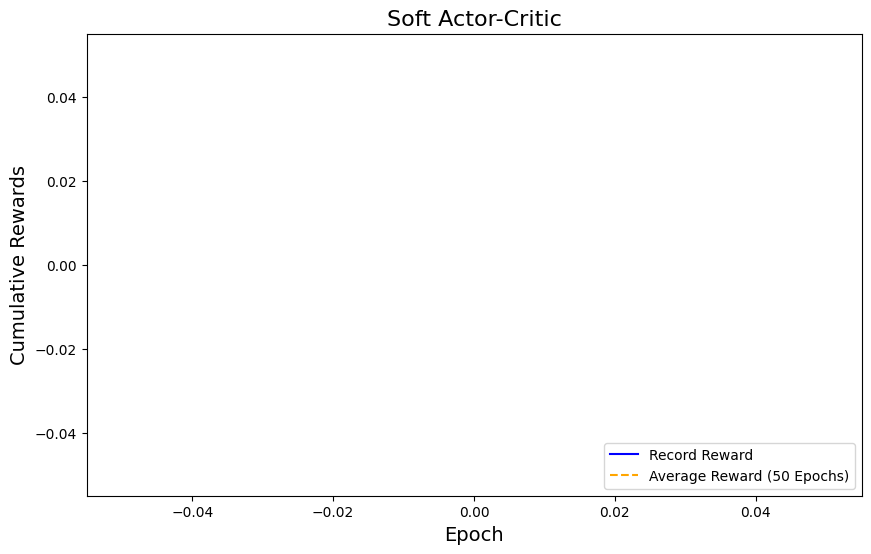

In [109]:
import matplotlib.pyplot as plt

# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    if idx < 50:
        avg_list = reward_records[:idx + 1]
    else:
        avg_list = reward_records[idx - 49:idx + 1]
    average_reward.append(np.average(avg_list))

# Plot both reward records and average rewards
plt.figure(figsize=(10, 6))
plt.plot(reward_records, label='Record Reward', color='blue')
plt.plot(average_reward, label='Average Reward (50 Epochs)', color='orange', linestyle='--')

# Add title and labels
plt.title('Soft Actor-Critic', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cumulative Rewards', fontsize=14)

# Add legend
plt.legend(loc='lower right')

# Save and show the plot
plt.savefig('sac_returns.png', dpi=300)
plt.show()

You are welcome to explore different continuous action environments by simply changing the environment code (might need additional package installation), for example:

```python
env = gym.make("HalfCheetah-v4")
```
We encourage you to write your own evaluation function and save the simulation visualization as a GIF file. This will not be graded, but it's fun to try.

Here are some potential complex tasks you can explore:  [RL environment list](https://github.com/clvrai/awesome-rl-envs).